In [1]:
#Import necessary modules for the script
import os
import sys
import h5py
import time
import random
%run LoadNotebook
%matplotlib inline
import numpy as np
import DataProcess as R
import scipy.special as sp
from scipy.special import kn
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.integrate as integrate
plt.style.use('apw-notebook.mplstyle')

importing Jupyter notebook from DataProcess.ipynb


### Electron spectrum via SDA (ref: Park et.al 2013)


Analytical treatment of particle encounters with a shock front follow from the fact that quantity $p^2\sin\alpha^2/B$ is essentially unchanged by the encounter (equivalent to the conservation of the first adiabatic invariant), where p is the particle momentum, B is the magnetic field, $\alpha$ is the pitch angle, angle between p and B. Since there is no electric field in dHT frame, and stationary magnetic field do not work, $p_1^\prime = p_2^\prime$. Conservation law implies that $\sin^2\alpha_2^\prime = \sin^2\alpha_1^\prime (B_2/B_1)$. Condition for reflection is $ \sin^2\alpha_1^\prime (B_2/B_1)>1$. In other words:

$\beta_\parallel^\prime>0$, $\beta_\perp^\prime >\beta_\parallel^\prime \tan\alpha_0$ where $\alpha_0 = \sin^{-1}\sqrt{B_1/B_2}\simeq \sin^{-1}\sqrt{1/r}$

Reflection condition with electric potential $e\Phi<0$ in dHT frame is :

$\beta_\perp^\prime > \sqrt{\left(\beta_\parallel^{\prime 2} -\frac{2e\Phi}{m_ec^2}\right)}\tan \alpha_0, \beta_\parallel^\prime >0$

Using lorentz transformation between dHT frame and upstream rest frame

$ \beta_\parallel^\prime = \frac{\beta_\parallel -\beta_s}{1-\beta_\parallel\beta_s}, \beta_\perp^\prime = \frac{\beta_\perp}{\gamma_s(1- v_\parallel \beta_s)}$

where $\beta_s = V_{sh}/(c\cos\theta_B),\gamma_s = 1/\sqrt{1-\beta_s^2}$

Reflection condition in upstream rest frame is

$\beta_\perp >\gamma_s \tan\alpha_0 \left[ (\beta_\parallel -\beta_s)^2 - \frac{2e\Phi}{m_e c^2}(1-\beta_s\beta_\parallel)^2\right]^{1/2}$  , and $\beta_\parallel >\beta_s$


The velocity in dHT frame after the reflection is given by: $\beta_{r\parallel}^\prime = -\beta_{i\parallel}^\prime, \beta_{r\perp}^\prime = \beta_{i\perp}^\prime$

In the upstream rest frame, one gets:
$\beta_{i\parallel} = \frac{2\beta_s - \beta_{r\parallel}(1+\beta_s^2)}{1-2\beta_{r\parallel}\beta_s+\beta_s^2}, \beta_{i\perp} = \frac{\beta_{r\perp}}{\gamma_s^2 (1-2\beta_s\beta_{r\parallel} + \beta_s^2)}$

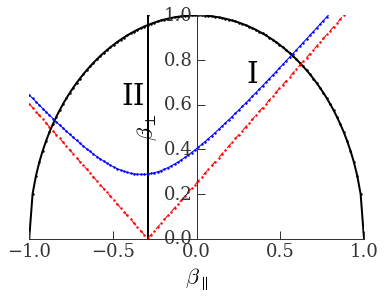

In [2]:
'''
SDA reflection condition including electric potential
'''
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#spine placement data centered
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel(r'$\beta_\parallel$')
ax.set_ylabel(r'$\beta_\perp$')

# Plot light speed circle
beta_parallel = np.linspace(-1,1,100)
circ = np.sqrt(1-beta_parallel**2)
ax.plot(beta_parallel,circ,color='k',linewidth=2)


# Electric potential is ZERO!
r = 2.5 # compression ratio
alpha0 = np.arcsin(1/np.sqrt(r))
beta_s = -0.293
gamma_s = 1./np.sqrt(1-beta_s**2)
beta_perp = gamma_s*np.tan(alpha0)*np.abs(beta_parallel-beta_s)
ax.axvline(x=beta_s,color='k',linewidth=2)
ax.plot(beta_parallel,beta_perp,color='r',linestyle='--')
ax.set_ylim([0,1.])

# with electrical potential ePhi = -0.00686 in unit of m_e c^2
ePhi = -0.00686*10
beta_perp = gamma_s*np.tan(alpha0)*((beta_parallel-beta_s)**2\
            -2*ePhi*(1-beta_s*beta_parallel)**2)**0.5
ax.plot(beta_parallel,beta_perp,'b')
plt.text(0.3,0.7,'I',size= 30,rotation=0)
plt.text(-0.45,0.6,'II',size= 30,rotation=0)

Incoming electrons in region I are transferred to region II after reflection. 

No reflection happens at the shock front in the superluminal shocks as $\beta_s$ approaches to -1. 

The threshold energy is given by the shortest distance from the origin to the hyperbolic curve. 

$E_{{\rm thres}} = \left(1/\sqrt{1-\beta_{{\rm thres}}^2}-1 \right)m_e c^2$
where $\beta_{{\rm thres}} = \sqrt{\frac{D^2[(1-\beta_s)^2D^2P^2\left[P-(1+\beta_s^2)\right]+\beta_s^2 -P]}{1+D^2(1-P\beta_s^2)}} $, $D = \gamma_s \tan\alpha_0$, $P = 2e\Phi/m_ec^2$.

Transition energy between thermal and non-thermal energy is given by 

$E_{{\rm trans}} = \left(1/\sqrt{1-\beta_{{\rm trans}}^2}-1 \right)m_e c^2$,
$\beta_{{\rm trans}} = \sqrt{\beta_s^2 - (1-\beta_s^2)(2e\Phi/m_ec^2)\tan^2\alpha_0}$


$E_{2,e}$ is the maximum energy ratio of the reflected to the incoming electrons giving 

by Ball&Melrose 2011 in non-relativistic limit:

$E_{2,e} = \left(1/\sqrt{1-\beta_2^2}-1 \right)m_e c^2$,
$\beta_2 = 2\beta_s \cos(\alpha_0/2)$


Beyond $E_{2,e}$, the spectral index $\delta$, defined as $f\propto E^{-\delta}$, increases. 

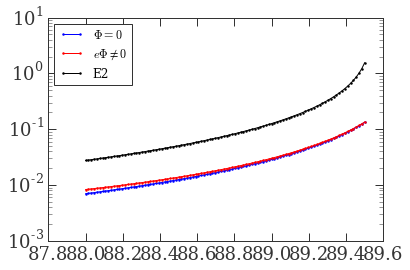

In [3]:
'''
Plot E_trans and E_2 as a function of theta_b
'''

r       = 2.5  # compression ratio
alpha0  = np.arcsin(1/r)

theta   = np.linspace(88,89.5,100)
theta_b = theta*np.pi/180.
beta_s  = 0.0041/np.cos(theta_b)
gamma_s = 1./np.sqrt(1-beta_s**2)
D       = gamma_s*np.tan(alpha0)
ePhi    = -0.00686
P       = 2*ePhi     # P = 2ePhi/m_e C^2 


# ePhi =0
beta_trans = beta_s
E_trans = 1./np.sqrt(1-beta_trans**2)-1 
plt.semilogy(theta, E_trans,color='b',label=r'$\Phi=0$')

# ePhi !=0
beta_trans = np.sqrt(beta_s**2 - (1.-beta_s**2)*P*np.tan(alpha0)**2)
E_trans = 1./np.sqrt(1-beta_trans**2)-1 # in unit of m_e c^2
plt.semilogy(theta, E_trans,color='r', label=r'$e\Phi\neq 0$')

beta_2 = 2*beta_s*np.cos(alpha0/2.)
E_2  = 1./np.sqrt(1-beta_2**2)-1
plt.semilogy(theta,E_2,color='k',label='E2')
plt.legend(loc=2)

The reflected electron distribution in the upstream rest frame is written as
$f_r(\beta_r) = f_i[\beta_i(\beta_r)](d^3\beta_i/d^3\beta_r)\Theta(\beta_s - \beta_{r\parallel})\times \Theta\left(\beta_{r\perp}- \gamma_s\tan\alpha_0\left[(\beta_s-\beta_{r\parallel})^2-\frac{2e\Phi}{m_e c^2}(1-\beta_s\beta_{r\parallel})^2\right]^{1/2}\right)$

Where $\Theta$ is the step function and $d^3\beta_i/d^3\beta_r$ is given by Jacobian determinant. 

$\frac{d^3 \beta_i}{d^3 \beta_r} = \frac{\beta_{i\perp}}{\beta_{r\perp}}\frac{\partial (\beta_{i,\perp},\beta_{i,\parallel})}{\partial(\beta_{r,\perp},\beta_{r,\parallel})} = \frac{(1-\beta_s)^4}{(1-2\beta_s\beta_{r\parallel}+ \beta_s^2)^4}$

First we try k-distribution for incoming electrons

$f_i(\beta_i) = c_k \left(1+ \frac{2(\gamma_i-1)}{2\kappa-3}\frac{m_e c^2}{T} \right)^{-\kappa-1}$

where $\gamma_i = 1/\sqrt{1-\beta_i^2}$ and $c_k = 1/\int d^3\beta_i f_i(\beta_i)$.

Upstream electron energy distribution $ f(E) = f(\beta) d\beta/dE$. 

$f(\beta) = \begin{pmatrix} 2\pi\beta^2\int_{-1}^1dt f_i(\beta), {\rm for },  \beta<\beta_{thres} \\
2\pi\beta^2 \left(\int_{-1}^{t_3} dt+\int_{t_1}^1dt\right) f_i(\beta) + 2\pi\beta^2 \int_{t_3}^{t_1}dt \frac{d^3\beta_i}{d^3\beta_r} f_i[\beta_i(\beta,t)], {\rm for}, \beta_{thres}<\beta<\beta_{trans} \\ 
2\pi\beta^2 \int_{t_3}^{t_2}dt \frac{d^3\beta_i}{d^3\beta_r} f_i[\beta_i(\beta,t)]+2\pi\beta^2\left( \int_{-1}^{t_2}dt + \int_{t_1}^1dt\right)f_i(\beta), {\rm for}, \beta\geq \beta_{trans} \\ 
\end{pmatrix}$

('E_trans=', 11.294427359358464)
Error in t1/t3!
Error in t1/t3!
Error in t1/t3!


/usr/licensed/anaconda/4.1.1/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/licensed/anaconda/4.1.1/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[1, 100.0, 1e-08, 10.0]

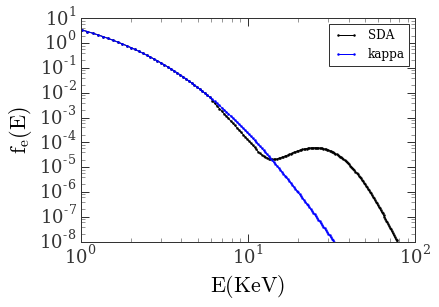

In [4]:
me      = 511 #k
num     = 200
beta    = np.linspace(0.0001,0.5,num)
fe      = np.linspace(0,1,num)
gamma   = 1./np.sqrt(1.-beta**2)
Energy  = (gamma-1)*me

'''
kappa distribution
'''
Te       = 0.8/me
kappa    = 10
f_kappa0 = (1.+2*(gamma-1)/(2*kappa-3)/Te)**(-kappa-1.)
dBetadE  = (1.-beta**2)**1.5/beta
f_kappaE = f_kappa0*dBetadE


theta_b = 80*np.pi/180.       # angle between B and shock normal
beta_s  = -0.032/np.cos(theta_b) # dHT and upstream rest frame Transformation v.
r       = 2.5             # compression ratio
alpha0  = np.arcsin(1/np.sqrt(r))
D       = np.tan(alpha0)/np.sqrt(1-beta_s**2) # D =gamma_s*tan(alpha0)
ePhi    =  -3.5            # electric potential
P       = 2.*ePhi/me      # P = 2ePhi/m_e C^2

beta_thres = np.sqrt((D**2*((1-beta_s)**2*D**2*P**2*(P-(1+beta_s**2))+\
            beta_s**2-P))/(1+D**2*(1-P*beta_s**2)))
beta_trans = np.sqrt(beta_s**2 -(1.-beta_s**2)*P*np.tan(alpha0)**2)
E_trans = 1./np.sqrt(1-beta_trans**2)-1.
print ('E_trans=', E_trans*me)

'''
solve t1, and t3. where t3<t2<t1
'''
def rootfun(x,i):
    return x**2*(1+D**2*(1-P*beta_s**2))- \
        2*x*D**2*beta_s/beta[i]*(1-P)+\
        D**2/beta[i]**2*(beta_s**2-P)-1

        
'''
integrate over SDA region
'''
def intsda(x,i):
    jac = (1-beta_s)**4/(1-2*beta_s*beta[i]*x+beta_s**2)**4
    sin = np.sqrt(1-x**2)
    betai_parallel = (2*beta_s- beta[i]*x*(1+beta_s**2))/(1-2*beta_s*beta[i]*x+beta_s**2)
    betai_perp     = beta[i]*sin/(1./np.sqrt(1-beta_s**2)*(1-2*beta_s*beta[i]*x+beta_s**2))
    betai  = np.sqrt(betai_parallel**2+betai_perp**2)
    gammai = 1./np.sqrt(1-betai**2)    
    return jac*(1.+2*(gammai-1)/(2*kappa-3)/Te)**(-kappa-1.)


for i in range(num):
    f_kappa= (1.+2*(gamma[i]-1)/(2*kappa-3)/Te)**(-kappa-1.)
    if beta[i]<beta_thres:
        fe[i]= 2.*f_kappa
    else:
        t3 = fsolve(rootfun,-1.,args=(i))  
        t1 = fsolve(rootfun,1.,args=(i))  
        if np.abs(t1)>1. or np.abs(t3)>1. or t1<t3:
            print ('Error in t1/t3!')
            #sys.exit()            
        if beta[i]<beta_trans:
            result = integrate.quad(intsda, t3, t1, args=(i))
            fe[i] = (2.-(t1-t3))*f_kappa + result[0]
        else:
            result = integrate.quad(intsda, t3, beta_s/beta[i], args=(i))
            fe[i] = (2-(t1-beta_s/beta[i]))*f_kappa+ result[0]
    fe[i] *= 0.5
    
plt.loglog(Energy,fe*dBetadE,'k',label='SDA')
plt.loglog(Energy,f_kappaE,'b',label='kappa')
plt.xlabel(r'$\rm E(KeV)$')
plt.ylabel(r'$\rm f_e(E)$')
plt.legend()
plt.axis([1,1e2, 1e-8,1e1])

### Generalize SDA theory to relativistic regime (ref: Guo et al 2015)

Reflection condition in relativistic regime is

$ \beta_\parallel^\prime <0$

$\beta_\perp^\prime >\sqrt{\frac{(\gamma_i+\Phi)^2-1}{\gamma_i^2}}\sin\alpha_0$

Transformation between dHT frame and upstream rest frame is

$\gamma^\prime = \gamma\gamma_s (1- \beta_s\beta_\parallel)$

Reflection condition for upstream rest frame is

$\beta_\parallel<\beta_s$

In the limit $\Phi\simeq 0$, we have $\beta_\perp>\gamma_s(\beta_s-\beta_\parallel)\tan\alpha_0$

Lower boundary of energy allowed for SDA reflection is

$\beta^2 = (1+\gamma_s^2\tan^2\alpha_0)\beta_\parallel^2 - 2\gamma_s^2\beta_s\beta_\parallel\tan^2\alpha_0+\gamma_s^2\beta_s^2\tan^2\alpha_0$

The minimum of this quadratic equation gives the minimum velocity in the upstream rest frame

$\beta_{\rm min}  = \beta_s \sqrt{\frac{\tan^2\alpha_0}{\tan^2\alpha_0 + 1/\gamma_s}}$

It follows that, with increasing $\beta_s$, i.e. for higher shock velocity or magnetic obliquity, the
minimum energy required to participate in the SDA process will increase. The fraction of particles that
can participate SDA decreases. The reflection fraction drops further with increasing $\Phi>0$. 


Post reflection Lorentz factor and velocity are related to the pre-reflection values by

$\gamma_r = \gamma_i \left(1+ \frac{2\beta_s(\beta_s- \beta_\parallel)}{1-\beta_s^2} \right) = \gamma_i(1+\Delta) $

$\beta_{r,\parallel} = \gamma_s^2 \left(\frac{2\beta_s-\beta_\parallel[1+\beta_s^2]}{1+\Delta} \right) $

$\beta_{r,\perp} = \frac{\beta_\perp}{1+\Delta}$

vsh_up= 0.227272727273


/usr/licensed/anaconda/4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in sqrt


[-1, 1, 0, 1.2]

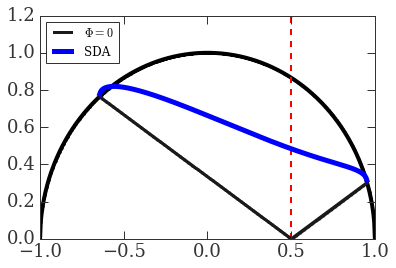

In [5]:
# Plot light speed circle
beta_parallel = np.linspace(-1.,1,500)
circ = np.sqrt(1-beta_parallel**2)
plt.plot(beta_parallel,circ,c='k',lw=4,ls='-')

vs0 = 0.08
v0  = 0.15
vsh_up = (vs0+v0)/(1+vs0*v0)
print 'vsh_up=',vsh_up
beta_s = vsh_up/np.cos(63./180.*np.pi)
gamma_s = 1./np.sqrt(1-beta_s**2)


r      = 4.        # r = B/B0
alpha0 = np.arcsin(1./np.sqrt(r))
plt.axvline(x=beta_s,lw=2,c='r',ls='--')
beta_perp = gamma_s*np.abs(beta_parallel-beta_s)*np.tan(alpha0)
plt.plot(beta_parallel[beta_perp<circ],beta_perp[beta_perp<circ],label=r'$\Phi=0$',lw=3)

ePhi = 0.5  # ePhi = Delta(Phi)/m_e*c^2
beta_para_HT = (beta_parallel-beta_s)/(1-beta_parallel*beta_s)
beta_perp_HT = gamma_s*np.abs(beta_para_HT-beta_s)*np.tan(alpha0)

beta_perp = gamma_s*(1-beta_s*beta_parallel)*np.sqrt(beta_para_HT**2*np.tan(alpha0)**2+\
            2*ePhi*np.sqrt(1./r-beta_para_HT**2*np.tan(alpha0)**2)*\
            np.sqrt(1./r)+ePhi**2*(1./r-beta_para_HT**2*np.tan(alpha0)**2))

plt.plot(beta_parallel,beta_perp,c='b',label='SDA',lw=5)
plt.legend(loc=2)
plt.axis([-1,1,0,1.2])

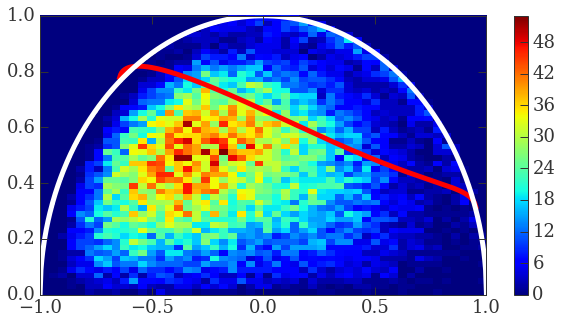

In [6]:
# Distribution from simualations
path = '/tigress/ruix/new_simu/1dang70mass100/output/'

ind  = 10
xL   = 100
xR   = 500
vex  = R.readprtl(path,'ve',ind) # gamma*beta
vey  = R.readprtl(path,'ue',ind)
vez  = R.readprtl(path,'we',ind) 
gamprt=np.sqrt(1.+vex**2+vey**2+vez**2)
vex /= gamprt
vey /= gamprt
vez /= gamprt  # beta

    
btheta = R.readparam(path,'btheta',ind)
vpara  = vex*np.cos(btheta)+vey*np.sin(btheta)
vp     = -vex*np.sin(btheta)+vey*np.cos(btheta)
vperp  = np.sqrt(vp**2+vez**2)

xe   = R.readprtl(path,'xe',ind)/R.readparam(path,'c_omp')
ishf,xshf,sh_speed = R.shfind(path,ind)
xL += xshf
xR += xshf
in_range = (xe>xL) & (xe<xR)

plt.figure(figsize=(10,5))

plt.plot(beta_parallel,beta_perp,c='r',label='SDA',lw=5)
plt.plot(beta_parallel,circ,c='w',lw=5,ls='-')
plt.axis([-1,1,0,1])
plt.hist2d(vpara[in_range], vperp[in_range], bins=50,range=[[-1,1], [0,1]])
plt.colorbar()

In [7]:
'''
tables are integrated PDFs for initialization of maxwellians for electrons and ions
delgam in the input file sets the temperature in delta gamma, here it is converted 
between species by multiplying by mass.
!! gamma_table is gamma -1 table
'''
def init_maxw_table(delgam,pdf_sz):
    maxg        = (delgam)*20+1.
    gamma_table = np.linspace(0,0,pdf_sz)
    pdf_table   = np.linspace(0,0,pdf_sz)
    for i in range(pdf_sz):
        gamma_table[i]=(maxg-1.)/(pdf_sz-1)*i
    # a safer way of writing gamma*sqrt(gamma^2-1)*exp(-(gamma-1)/delgam)
    func=(gamma_table+1.)*np.sqrt(gamma_table*(gamma_table+2.))*np.exp(-(gamma_table)/delgam)  
    pdf_table[0]=0.
    for i in range(1,pdf_sz):
        pdf_table[i]=sum(func[0:i+1])
    #normalize pdf_table         
    pdf_table=pdf_table/pdf_table[pdf_sz-1]
    return gamma_table,pdf_table

In [8]:
# Maxwell distribution for the particles
def init_rel_maxwell(gamma0,pdf_sz,gamma_table,pdf_table):
    gamma0mag = np.abs(gamma0)
    beta_drift = np.sign(gamma0)*np.sqrt(1.-1./max(abs(gamma0),1.)**2)
    
    random.seed(time.time())    
    rannum = random.uniform(0,1)
    if (rannum==1.):
        rannum = random.uniform(0,1)
    gam=0. #gam = gamma-1., only kinetic energy to avoid underflows
    #choose gamma from the table
    for i in range(pdf_sz):               
        if(i==pdf_sz-1):
            gam=gamma_table[pdf_sz-1]
        if(rannum > pdf_table[i] and rannum < pdf_table[i+1]):                      
            gam=gamma_table[i]+(gamma_table[i+1]-gamma_table[i]) \
            /(pdf_table[i+1]-pdf_table[i])*(rannum-pdf_table[i])
            break
    
    pcosth = 2*random.uniform(0,1)-1
    pphi   = random.uniform(0,1)*2*np.pi
    psinth = np.sqrt(1-pcosth**2)   
    
    # v0t = beta
    v0t = np.sqrt((gam)*(gam+2.))/(1.+gam)     
    ut1 = v0t*psinth*np.cos(pphi)
    vt1 = v0t*psinth*np.sin(pphi)
    wt1 = v0t*pcosth
    
    # aka Zenitani 2015, u = gam*v, including c factor
    ptx = (1.+gam)*ut1
    pty = (1.+gam)*vt1
    ptz = (1.+gam)*wt1
    # flipping method aka Zenitani 2015, TABLE II
    X7  = random.uniform(0,1)
    if (-beta_drift*ut1>X7):
        ptx = -ptx
    # particles will have average velocity beta0 (with sign)    
    px1 = (ptx+beta_drift*(gam+1.))*gamma0mag #this will include the sign of gamma0
    py1 = pty
    pz1 = ptz
    
    gam1=np.sqrt(1+px1**2+py1**2+pz1**2)

    u=px1/gam1
    v=py1/gam1
    w=pz1/gam1
    return gam1,u,v,w

In [9]:
pdf_sz = 1000
num    = 100000
delgam = 0.17 # delgam = k T/m c^2
gamma_table,pdf_table = init_maxw_table(delgam,pdf_sz)

ux  = np.empty(num) # beta
uy  = np.empty(num)
uz  = np.empty(num)
gam0= np.empty(num)
for i in range(num):
    gam0[i],ux[i],uy[i],uz[i] = init_rel_maxwell(1.,pdf_sz,gamma_table,pdf_table)
    

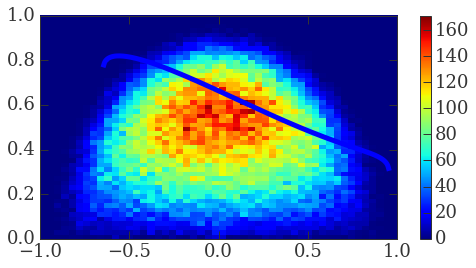

In [10]:
#plt.figure(figsize=(8,8))
#plt.hist2d(ux,uy, bins=40,range=[[-1,1], [-1,1]])
#plt.colorbar()
bpa = ux*np.cos(btheta) +  uy*np.sin(btheta)
u0  = -ux*np.sin(btheta) + uy*np.cos(btheta)
bpr = np.sqrt(u0**2+uz**2)
plt.figure(figsize=(8,4))
plt.hist2d(bpa,bpr, bins=50,range=[[-1,1], [0,1]])
plt.colorbar()
plt.plot(beta_parallel,beta_perp,c='b',label='SDA',lw=5)

In [11]:
'''
Construct Synthetic spectrum before and after SDA 
(In upstream rest frame)
'''
def Prtl_SDA(beta_parallel,beta_perp,bpa,bpr,gam0):
    bpa0 = np.copy(bpa)
    bpr0 = np.copy(bpr)
    gam  = np.copy(gam0)
    
    beta_ind = np.searchsorted(beta_parallel,bpa)
    
    for i in range(len(beta_parallel)):
        if not np.isnan(beta_perp[i]):
            beta_para_start = beta_parallel[i]
            break
        
    ind = 0
    for i in range(num):
        #check if the particle is reflected
        if bpa[i]>beta_s or bpa[i]<beta_para_start:
            pass
        elif bpr[i]<=beta_perp[beta_ind[i]]:
            pass
        else:
            ind += 1
            # calculate reflected particles' momentum/energy
            gamma_tmp = 1./np.sqrt(1.-bpa[i]**2-bpr[i]**2)
            Delta = 2*beta_s*(beta_s-bpa[i])/(1-beta_s**2)
            gamma_r = gamma_tmp*(1+Delta)
        
            bpa0[i] = gamma_s**2*(2*beta_s-bpa[i]*(1+beta_s**2))/(1+Delta)
            bpr0[i] = bpr[i]/(1+Delta)
            gam[i] = 1./np.sqrt(1-bpa0[i]**2-bpr0[i]**2)
            
    print 'fraction=', float(ind)/num,  'ind=',ind
    return bpa0,bpr0,gam

In [12]:
def dist_prtl(gam1):
    gambins = 200      
    gamma_list  = np.logspace(-4,1,gambins) # gamma-1
    fe = np.empty(len(gamma_list))   
    for k in range(len(fe)):
        if k==0:
            fe[k] = sum(gam1<gamma_list[0]+1)/num
        ar = (gam1>gamma_list[k-1]+1) & (gam1<gamma_list[k]+1)
        fe[k] = float(sum(ar))/len(gam1)
    return gamma_list, fe 



fraction= 0.17244 ind= 17244


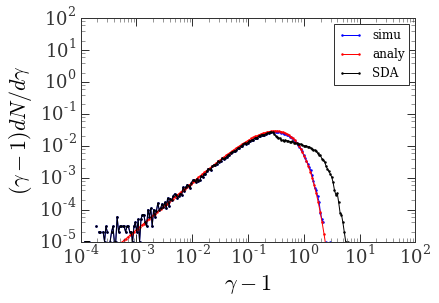

In [14]:
# Incoming Maxwellian plasma spectrum
gamma_list, fe = dist_prtl(gam0)
plt.loglog(gamma_list,fe,c='b',lw=1,label='simu')

gamma,fgamma = R.SetT(path,mass=1., DelGam=delgam, ind=0,spect_type='energy',rangex=-4,rangey=3,num=200)
plt.loglog(gamma,fgamma/16.,lw=1,c='r',label='analy')


# spectrum after SDA
bpa_sda,bpr_sda,gam_sda = Prtl_SDA(beta_parallel,beta_perp,bpa,bpr,gam0)

gamma_list, fe = dist_prtl(gam_sda)
plt.loglog(gamma_list,fe,c='k',lw=1,label='SDA')


# plot setting
plt.axis([1e-4,1e2,1e-5,1e2])
plt.legend()
plt.xlabel(r'$\gamma-1$')
plt.ylabel(r'$(\gamma-1)dN/d\gamma$')

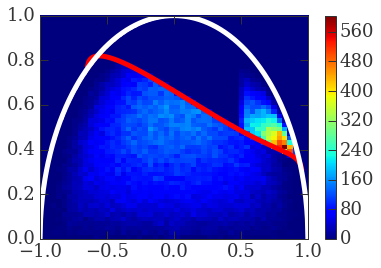

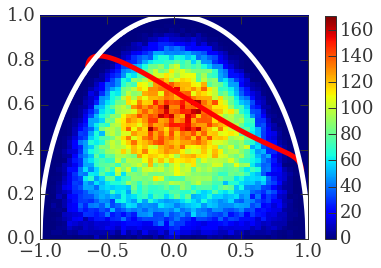

In [15]:
'''
Electron phase space plot before and after SDA
'''
plt.plot(beta_parallel,beta_perp,c='r',label='SDA',lw=5)
plt.plot(beta_parallel,circ,c='w',lw=5,ls='-')
plt.axis([-1,1,0,1])
plt.hist2d(bpa_sda,bpr_sda, bins=50,range=[[-1,1], [0,1]])
plt.colorbar()
fig = plt.figure()
plt.plot(beta_parallel,beta_perp,c='r',label='SDA',lw=5)
plt.plot(beta_parallel,circ,c='w',lw=5,ls='-')
plt.hist2d(bpa,bpr, bins=50,range=[[-1,1], [0,1]])
plt.colorbar()

vsh_up= 0.227272727273


/usr/licensed/anaconda/4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in sqrt


[-1, 1, 0, 1.2]

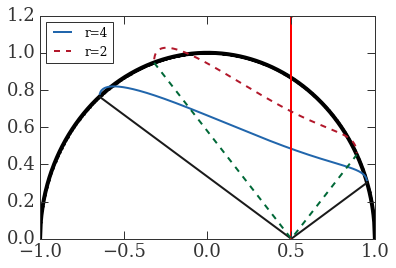

In [16]:
'''
Parameter study of SDA
'''
# Plot light speed circle
beta_parallel = np.linspace(-1.,1,500)
circ = np.sqrt(1-beta_parallel**2)
plt.plot(beta_parallel,circ,c='k',lw=4,ls='-')

vs0 = 0.08
v0  = 0.15
vsh_up = (vs0+v0)/(1+vs0*v0)
print 'vsh_up=',vsh_up
beta_s = vsh_up/np.cos(63./180.*np.pi)
#beta_s = vsh_up/np.cos(R.readparam('btheta'))
gamma_s = 1./np.sqrt(1-beta_s**2)

ls0 = ["-","--"]
label0 = ['r=4','r=2']
for i in range(2):
    r      = 4/(i+1.)        # r = B/B0
    alpha0 = np.arcsin(1./np.sqrt(r))
    plt.axvline(x=beta_s,lw=2,c='r')
    beta_perp = gamma_s*np.abs(beta_parallel-beta_s)*np.tan(alpha0)
    plt.plot(beta_parallel[beta_perp<circ],beta_perp[beta_perp<circ],ls0[i],lw=2)

    ePhi = 0.5  # ePhi = Delta(Phi)/m_e*c^2
    beta_para_HT = (beta_parallel-beta_s)/(1-beta_parallel*beta_s)
    beta_perp_HT = gamma_s*np.abs(beta_para_HT-beta_s)*np.tan(alpha0)

    beta_perp = gamma_s*(1-beta_s*beta_parallel)*np.sqrt(beta_para_HT**2*np.tan(alpha0)**2+\
            2*ePhi*np.sqrt(1./r-beta_para_HT**2*np.tan(alpha0)**2)*\
            np.sqrt(1./r)+ePhi**2*(1./r-beta_para_HT**2*np.tan(alpha0)**2))

    plt.plot(beta_parallel,beta_perp, ls0[i],lw=2,label=label0[i])
plt.legend(loc=2)
plt.axis([-1,1,0,1.2])


vsh_up= 0.227272727273


/usr/licensed/anaconda/4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in sqrt


[-1, 1, 0, 1.2]

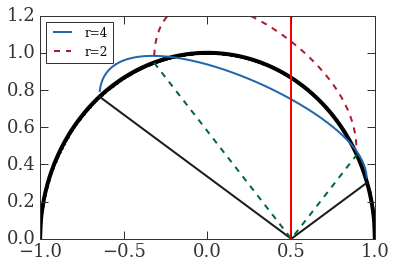

In [17]:
'''
Parameter study of SDA
'''
# Plot light speed circle
beta_parallel = np.linspace(-1.,1,500)
circ = np.sqrt(1-beta_parallel**2)
plt.plot(beta_parallel,circ,c='k',lw=4,ls='-')

vs0 = 0.08
v0  = 0.15
vsh_up = (vs0+v0)/(1+vs0*v0)
print 'vsh_up=',vsh_up
beta_s = vsh_up/np.cos(63./180.*np.pi)
#beta_s = vsh_up/np.cos(R.readparam('btheta'))
gamma_s = 1./np.sqrt(1-beta_s**2)

ls0 = ["-","--"]
label0 = ['r=4','r=2']
for i in range(2):
    r      = 4/(i+1.)        # r = B/B0
    alpha0 = np.arcsin(1./np.sqrt(r))
    plt.axvline(x=beta_s,lw=2,c='r')
    beta_perp = gamma_s*np.abs(beta_parallel-beta_s)*np.tan(alpha0)
    plt.plot(beta_parallel[beta_perp<circ],beta_perp[beta_perp<circ],ls0[i],lw=2)

    ePhi = 1.0  # ePhi = Delta(Phi)/m_e*c^2
    beta_para_HT = (beta_parallel-beta_s)/(1-beta_parallel*beta_s)
    beta_perp_HT = gamma_s*np.abs(beta_para_HT-beta_s)*np.tan(alpha0)

    beta_perp = gamma_s*(1-beta_s*beta_parallel)*np.sqrt(beta_para_HT**2*np.tan(alpha0)**2+\
            2*ePhi*np.sqrt(1./r-beta_para_HT**2*np.tan(alpha0)**2)*\
            np.sqrt(1./r)+ePhi**2*(1./r-beta_para_HT**2*np.tan(alpha0)**2))

    plt.plot(beta_parallel,beta_perp, ls0[i],lw=2,label=label0[i])
plt.legend(loc=2)
plt.axis([-1,1,0,1.2])